# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)
*Дедлайн -- 18 марта.*

*Червонцев Сергей (ФИВТ МФТИ)*

Привет! В этом задании мы будем предсказывать персонажа Южного парка по его фразе.

В задании четыре пункта, за которые суммарно можно получить 12 баллов. При этом максимум за задание - 10 баллов. Поэтому некоторые пункты можно пропустить.

### 1. Обработка данных

Сперва скачаем размечанные [диалоги из Южного Парка](https://www.kaggle.com/tovarischsukhov/southparklines/data) и изучим их. Для работы с таблицами нам потребуется [pandas](https://pandas.pydata.org/pandas-docs/stable/install.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, re, random
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [2]:
raw_df = pd.read_csv('All-seasons.csv')
raw_df.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [3]:
raw_df.describe()

,Season,Episode,Character,Line
count,70896,70896,70896,70896
unique,19,19,3950,64301
top,2,10,Cartman,What?\n
freq,6416,5271,9774,361


В нашем распоряжении ~70к фраз от ~4к персонажей с первого по восемнадцатый сезоны. Выкинем всех второстепенных персонажей:

In [4]:
# немного магии
lines_freqs = raw_df.groupby(['Character'])['Line'].count()
# оставляем персонажей, у которых больше восьмиста реплик
desired_freqs = (lines_freqs > 800)
main_characters = lines_freqs[desired_freqs].sort_values(ascending=False)
df = raw_df.loc[raw_df['Character'].isin(main_characters.keys())].copy()
character_to_id = {c: i for i,c in enumerate(main_characters.keys())}
print(main_characters)

Character
Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Name: Line, dtype: int64


In [5]:
# число оставшихся примеров
df.shape

(33284, 4)

Теперь нам нужно сделать *токенизацию* - проще говоря, разбить каждое предложение на отдельные слова, выкинув ненужные символы вроде "/n".

In [6]:
def tokenize_phrase(phrase_as_str):
    # ещё немного магии
    # r'\w+|\?|\!|,|\.' значит извлечь все слова и знаки "?","!",",","."
    # r'\w+' значит извлечь все слова
    # r'\w+|\.' значит извлечь все слова и знаки "."
    # ... ну вы поняли
    # уберите .lower(), чтобы слова типо "What" не преобразовывались в "what"
    return re.findall(r'\w+|\?|\!|,|\.', phrase_as_str.lower())

# проверим на случайном примере, что всё хорошо
rand_ex = df['Line'].sample().values[0]
print('Original:')
print('-'*10)
print(rand_ex)
print('-'*10)
print('Tokenized:')
print('-'*10)
print(tokenize_phrase(rand_ex), end=' ')

Original:
----------
What's the matter, Mr. Hankey? Are you sick?

----------
Tokenized:
----------
['what', 's', 'the', 'matter', ',', 'mr', '.', 'hankey', '?', 'are', 'you', 'sick', '?'] 

In [7]:
# токенизируем каждую реплику
df['Tokenized Line'] = df['Line'].apply(lambda row: tokenize_phrase(row))
raw_df['Tokenized Line'] = raw_df['Line'].apply(lambda row: tokenize_phrase(row))

df['Character Id'] = df['Character'].apply(lambda row: character_to_id[row])
df.head()

,Season,Episode,Character,Line,Tokenized Line,Character Id
0,10,1,Stan,"You guys, you guys! Chef is going away. \n","[you, guys, ,, you, guys, !, chef, is, going, ...",1
1,10,1,Kyle,Going away? For how long?\n,"[going, away, ?, for, how, long, ?]",2
2,10,1,Stan,Forever.\n,"[forever, .]",1
3,10,1,Chef,I'm sorry boys.\n,"[i, m, sorry, boys, .]",6
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...","[chef, said, he, s, been, bored, ,, so, he, jo...",1


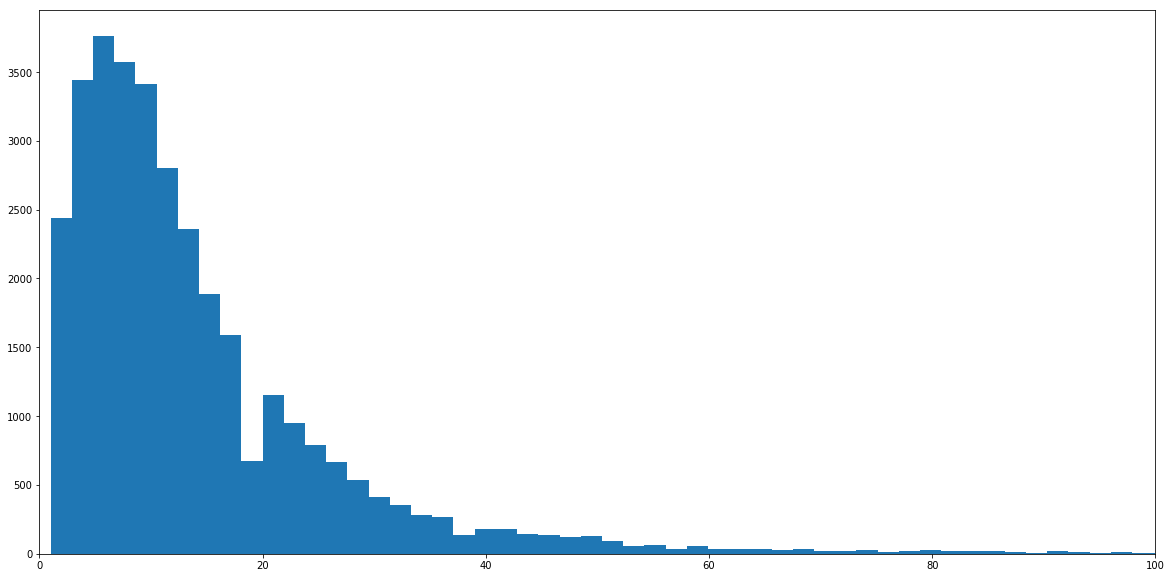

In [8]:
# считаем число "слов" в каждой реплике
words_len = df['Tokenized Line'].apply(lambda row: len(row))

plt.figure(figsize=(20,10))
plt.hist(words_len, bins=200)
plt.xlim((0,100))
plt.show()

In [9]:
# разбиваем данные на трейн и тест
train_df = df.sample(frac=0.85,random_state=200)
test_df = df.drop(train_df.index)
MAX_LEN = max([len(l) for l in df['Tokenized Line']])

Итак, мы решаем задачу классификации преимущественно коротких фраз (как видно из графика выше) на большое количество классов.

### 2. Обучение FastText

На прошлой лекции вы познакомились со схемой word2vec.

Для её обучения на наших конкретных данных нужно:
1. Склеить всё, что можно, в единый массив текста - *корпус*.
2. Проиндексировать слова в корпусе, выкинув слишком редкие.
3. Сделать генерацию примеров для обучения.
4. Реализовать cbow (предсказание центрального слова по контексту) или skip-gram (наоборот).
5. Обучить на корпусе и проверить корректность полученных векторов.

Основная проблема в таком подходе - время. В [самой лучшей](https://arxiv.org/abs/1712.09405) на обучение векторов тратится примерно три дня, при этом используется масса ухищрений и оптимизаций.


Можно было бы взять готовый word2vec и доучить его на наших данных, или использовать [tf-idf](https://www.kaggle.com/agaleana/predicting-south-park-dialogues), но мы пойдём другим путём.

А именно, напишем очень простую, но эффективную для классификации модель - [FastText](https://arxiv.org/abs/1607.01759).

Вся суть описывается картинкой:

<img src="http://wellyzhang.github.io/img/in-post/fastText/model.jpg">

Где output - это вектор размерности (в нашем случае) девять, отвечающий каждому классу.

В задании предлагается написать свой FastText, а также ответить на несколько вопросов.

1. Реализуйте FastText на девять классов(с обычным softmax). В качестве ошибки для обучения используете [Negative Log Likelihood](http://pytorch.org/docs/master/nn.html#nllloss). (5 баллов)
2. Как влияет на качество учёт знаков препинания и "мусорных" слов (предлогов, междометий), а также больших букв? Сравните качество модели в трёх случаях: со всеми словами и символами, без частых слов и символов (используйте nltk.corpus.stopwords) и без редких слов. Сделайте выводы. (2 балла)
3. В чём причина низкого качества решения? Приведите несколько примеров, на которых модель ошибается, и предложите, как можно её улучшить (2 балла).
4. Получите accuracy не ниже 42% на данных (вам поможет инициализация, dropout, а также [subsampling](https://arxiv.org/abs/1712.09405) (случайное удаление слов с вероятностью $\sqrt(\frac{1}{p(w)}),$ где $p(w)$ - частота, с которой встречается слово)) (3 балла). Если получите качество выше 50% (не меняя ничего в первой части) - 10 баллов автоматом.

In [10]:
# собираем корпус фраз
raw_corpus = []
# параллельно запоминаем словарь слов
raw_words_set = set()

for line in raw_df['Tokenized Line']:
    raw_corpus += line
    raw_words_set |= set(line)

print(' '.join(raw_corpus[234:334]))

it s true . but are you back for good ? that s right . hey everybody ! chef s back ! what ? all right ! yeah ! oh , finally ! wow ! it seems like you had a great time with the super adventure club , chef . they sound like really interesting people . yeah ! but now that you re back here , does that mean that you re not in the super adventure club anymore ? nnono ! ohhh , so have you decided you can still belong to the super adventure club but


In [11]:
words_set = raw_words_set
words_set |= set(['<end>'])
# некоторые из слов здесь можно выбросить
print('Vocab_size:', len(words_set))

Vocab_size: 25063


In [12]:
# индексируем слова
id_to_word = {i: word for i, word in enumerate(words_set)}
word_to_id = {word: i for i, word in enumerate(words_set)}

# corpus - вектор натуральных чисел от 0 до vocab_size 
corpus = np.array([word_to_id[word] for word in raw_corpus if word in words_set])

In [13]:
def process_phrase(phrase):
    # преобразование фразы в id-шники
    processed = [word_to_id['<end>']] * MAX_LEN
    for index, word in enumerate(phrase):
        if word in words_set:
            processed[index] = word_to_id[word]
    return processed

def sample_batch(df, batch_size=32, offset=None):
    # генерация примеров
    if offset is None:
        batch = df.sample(n=batch_size)
    else:
        batch = df.iloc[range(offset, 
                              min(offset + batch_size, len(df)))]
    phrases = batch['Tokenized Line'].values
    
    X_batch = np.array([process_phrase(phrase) for phrase in phrases])
    y_batch = batch['Character Id'].values
    phrase_lengths = np.array([len(phrase) for phrase in phrases])
    return X_batch, y_batch, phrase_lengths

In [27]:
ex_process = process_phrase(['oh', 'my', 'got', ',', 'they', 've', 'killed', 'kenny', '!'])
print([id_to_word[temp] for temp in ex_process][:30], '...', len(ex_process))

['oh', 'my', 'got', ',', 'they', 've', 'killed', 'kenny', '!', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>'] ... 381


In [14]:
class FastTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_classes):
        super(FastTextClassifier, self).__init__()
        <эмбеддинги из индексов в нужную размерность>
        <линейное преобразование>
        <инициализация весов>
    
    def init_emb(self, embed_dim, n_classes):
        <веса инициализируете так>
        my_layer.weight.data.uniform(-value, value)
        
    def forward(self, inputs, lengths):
        <получаем ненормированный score>
        <передаём в лог-софтмакс для использования в NLLLoss>
        return F.log_softmax(my_probs)

In [15]:
from sklearn.metrics import accuracy_score

def get_accuracy(df, model):
    # число правильных ответов модели
    cbatch_size = 32
    y_pred = np.zeros(len(df))
    
    for i in range(0, len(df), cbatch_size):
        batch_X, batch_y, batch_lengths = sample_batch(df, cbatch_size, offset=i)
        predictions_proba = torch.exp(model(Variable(torch.LongTensor(batch_X)), 
                          Variable(torch.FloatTensor(batch_lengths))))
        predictions = torch.max(predictions_proba, 1)[1]
        y_pred[i:min(i+cbatch_size, len(df))] = predictions
    return accuracy_score(y_pred, df['Character Id'])

In [16]:
EMBED_DIM = <размерность векторов>
LR = 1e-3

fast_clf = FastTextClassifier(len(words_set), EMBED_DIM, len(main_characters))
loss_function = <neg log likelihood>
optimizer = <adam>

print('Init accuracy:', get_accuracy(test_df, fast_clf))

Init accuracy: 0.17905067093931504


In [17]:
n_epochs = <число эпох>
batch_size = <размер батча>
n_steps_per_epoch = <число шагов за эпоху>

losses = []
accuracies = []
old_test_accuracy = 0

for epoch in range(n_epochs):
    epoch_loss = torch.Tensor([0])
    for i in range(n_steps_per_epoch):
        batch_X, batch_y, batch_lengths = sample_batch(train_df, batch_size)
        
        fast_clf.zero_grad()
        
        <Получение ответов по выборке, пересчёт лосса>
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_loss += batch_loss.data
        losses += [batch_loss.data]
    print('EPOCH:', epoch)
    print('AVG LOSSS:', epoch_loss.numpy()[0] / n_steps_per_epoch)
    test_accuracy = get_accuracy(test_df, fast_clf)
    accuracies += [test_accuracy]
    print('TEST ACCURACY:', test_accuracy)
    print('-'*10)
    if <Критерий остановки>:
        break
    else:
        old_test_accuracy = test_accuracy
print('FINISHED')

EPOCH: 0
AVG LOSSS: 1.841685851774604
TEST ACCURACY: 0.3128379731624274
----------
EPOCH: 1
AVG LOSSS: 1.7642229865579044
TEST ACCURACY: 0.3228519927899059
----------
EPOCH: 2
AVG LOSSS: 1.6911333869485294
TEST ACCURACY: 0.36611255758061284
----------
EPOCH: 3
AVG LOSSS: 1.6118695703566883
TEST ACCURACY: 0.3566993791307831
----------
EPOCH: 4
AVG LOSSS: 1.544486895945277
TEST ACCURACY: 0.39535349489285
----------
EPOCH: 5
AVG LOSSS: 1.4915567113263575
TEST ACCURACY: 0.39114760664930903
----------
EPOCH: 6
AVG LOSSS: 1.4398582769195418
TEST ACCURACY: 0.4121770478670138
----------
EPOCH: 7
AVG LOSSS: 1.3907952632299916
TEST ACCURACY: 0.4203885439615462
----------
EPOCH: 8
AVG LOSSS: 1.3481398362379808
TEST ACCURACY: 0.41798517925095136
----------
EPOCH: 9
AVG LOSSS: 1.305146644557763
TEST ACCURACY: 0.3971560184257961
----------
FINISHED


In [22]:
print('Final accuracy:', get_accuracy(test_df, fast_clf))

Final accuracy: 0.40216302823953537
